In [1]:
import numpy as np

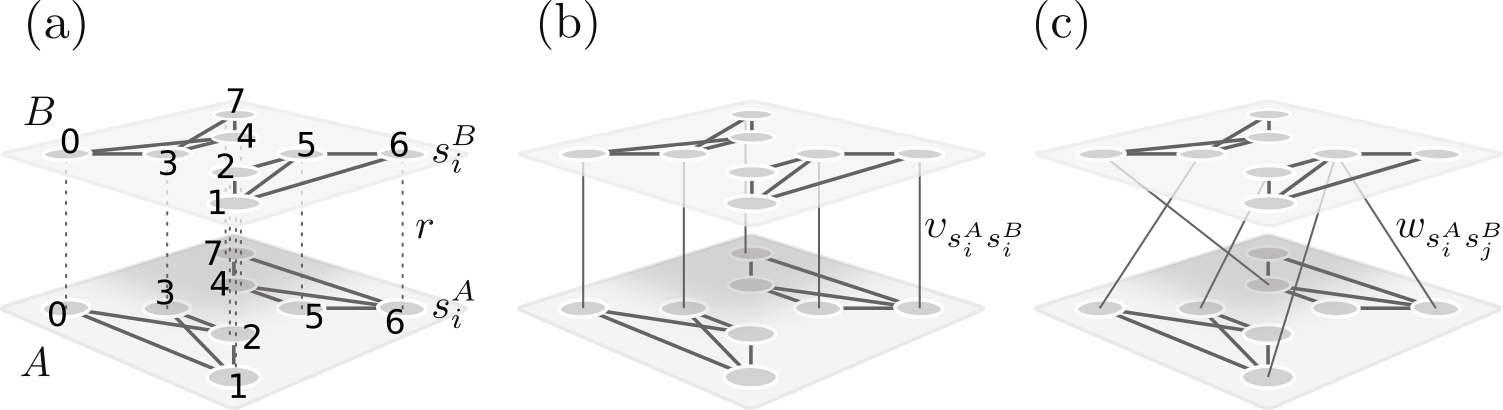

In [2]:
from IPython.display import Image
Image(filename='multilayer_network.png') 

# Define network

In [3]:
n_nodes = 8
n_layers = 2

# adjacency matrix
A = [[0,1,0], [0,2,0], [1,2,0], [1,3,0], [2,3,0],\
    [4,5,0], [4,6,0], [4,7,0], [5,6,0], [6,7,0],\
    [0,3,1], [0,4,1], [3,4,1], [3,7,1], [4,7,1],\
    [1,2,1], [1,5,1], [1,6,1], [2,5,1], [5,6,1]]

# Print multilayer network

In [4]:
# Print links
with open("network.dat", "w") as fout:
    for link in A:
        fout.write(" ".join(str(x) for x in link) + "\n")
        
        
# Print network in *Intra/Inter format        
with open("network_infomap.net", "w") as fout:
    
    fout.write("*Vertices " + str(n_nodes) + "\n")
    for n in range(1, n_nodes + 1):
        fout.write(str(n) + ' ' + '"' + str(n) + '"' + '\n')   
        
    fout.write("*Intra\n")
    for link in A:
        source, target, layer = link[0], link[1], link[2]
        fout.write(str(layer + 1) + " " + str(source + 1) + " " + str(target + 1) + " 1\n")
        fout.write(str(layer + 1) + " " + str(target + 1) + " " + str(source + 1) + " 1\n")        

# Print posterior network

In [8]:
use_self_links = True

# Multilayer format

prior_inter = np.log(n_layers) / (n_layers)    
prior_intra = np.log(n_nodes) / n_nodes / n_layers

M = {}
for l in range(n_layers):
    M[l] = np.zeros(n_nodes * n_nodes).reshape(n_nodes, n_nodes)        

S = np.log(n_nodes) / n_layers * np.ones(n_layers * n_nodes).reshape(n_layers, n_nodes) # intra-layer node strength (intra-layer prior + observed links)
 
with open("network.dat", "r") as fin:        
    for line in fin:
        n1, n2, l = line.split()            
        n1, n2, l = int(n1), int(n2), int(l)
        M[l][n1][n2] = 1
        M[l][n2][n1] = 1
        S[l][n1] += 1
        S[l][n2] += 1

with open("posterior_network_self_links.dat", "w") as fout:
    fout.write("*Vertices " + str(n_nodes) + "\n")
    for i in range(1, n_nodes + 1):
        fout.write(str(i) + ' ' + '"' + str(i) + '"' + '\n')
    fout.write("*Multilayer\n")

    if not use_self_links:
        # intra links
        for l in range(n_layers):
            for n1 in range(n_nodes):
                for n2 in range(n_nodes):
                    if n1 != n2:
                        intra_weight = prior_intra + M[l][n1][n2]
                        fout.write(" ".join(str(x) for x in [l+1, n1+1, l+1, n2+1, intra_weight]) + "\n")
        # inter links             
        for l1 in range(n_layers):
            for l2 in range(n_layers):
                if l1 == l2:
                    continue
                for n1 in range(n_nodes):
                    for n2 in range(n_nodes):
                        if n1 != n2:
                            diagonal_weight = prior_inter * (prior_intra + M[l2][n1][n2]) / S[l2][n1]
                            fout.write(" ".join(str(x) for x in [l1+1, n1+1, l2+1, n2+1, diagonal_weight]) + "\n")
    else:
        # Allow both intra-layer and inter-layer (from first vertical step) self-links, add both intra-layer and inter-layer links in one loop
        for l1 in range(n_layers):
            for l2 in range(n_layers):
                is_intra = l1 == l2
                for n1 in range(n_nodes):
                    for n2 in range(n_nodes):
                        intra_weight = prior_intra + M[l2][n1][n2]
                        inter_weight = prior_inter * intra_weight / S[l2][n1]
                        weight = inter_weight
                        if is_intra:
                            weight += intra_weight
                        s = " ".join(str(x) for x in [l1+1, n1+1, l2+1, n2+1, weight])
                        fout.write(s + "\n")